In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import umap
import umap.plot
import random
import pickle
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from PIL import Image

from sklearn.metrics.pairwise import cosine_similarity

from scipy.io import loadmat
from revisitop.python.evaluate import compute_map, compute_ap

from torchvision.models import resnet50, ResNet50_Weights

/home/alcontreras/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/alcontreras/.local/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


## Carga de modelo ResNet50

In [2]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [3]:
class GeM_ResNet(nn.Module):    
    def __init__(self, features, pool):
        super(GeM_ResNet, self).__init__()
        self.features = nn.Sequential(*features)
        self.pool = pool
    
    def forward(self, x):
        o = self.features(x)
        o = self.pool(o).squeeze(-1).squeeze(-1)
        return o

In [4]:
weights = ResNet50_Weights.DEFAULT
model_resnet50 = resnet50(weights=weights)

features = list(model_resnet50.children())[:-2]
pool = GeM()

model_gem = GeM_ResNet(features, pool)
model_gem

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gem.to(device)

GeM_ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

## Creacion datasets de torch

In [5]:
file_rox = "revisitop/data/datasets/roxford5k/gnd_roxford5k.pkl"
with open(file_rox, "rb") as f1:
    data_roxford5k = pickle.load(f1)

In [132]:
import os
import pickle

DATASETS = ['oxford5k', 'paris6k', 'roxford5k', 'rparis6k']

def configdataset(dataset, dir_main):

    dataset = dataset.lower()

    if dataset not in DATASETS:    
        raise ValueError('Unknown dataset: {}!'.format(dataset))

    # loading imlist, qimlist, and gnd, in cfg as a dict
    gnd_fname = os.path.join(dir_main, dataset, 'gnd_{}.pkl'.format(dataset))
    with open(gnd_fname, 'rb') as f:
        cfg = pickle.load(f)
    cfg['gnd_fname'] = gnd_fname

    cfg['ext'] = '.jpg'
    cfg['qext'] = '.jpg'
    cfg['dir_data'] = os.path.join(dir_main, dataset)
    cfg['dir_images'] = os.path.join(cfg['dir_data'], 'jpg')

    cfg['n'] = len(cfg['imlist'])
    cfg['nq'] = len(cfg['qimlist'])

    cfg['im_fname'] = config_imname
    cfg['qim_fname'] = config_qimname

    cfg['dataset'] = dataset

    return cfg

def config_imname(cfg, i):
    return os.path.join(cfg['dir_images'], cfg['imlist'][i] + cfg['ext'])

def config_qimname(cfg, i):
    return os.path.join(cfg['dir_images'], cfg['qimlist'][i] + cfg['qext'])

In [ ]:
os.path.join(dir_main, dataset, 'gnd_{}.pkl'.format(dataset))

In [133]:
a = configdataset("oxford5k",)

TypeError: configdataset() missing 1 required positional argument: 'dir_main'

In [6]:
dataset_name ="roxford5k"

dataset_train = []
dataset_val = []

preprocess = weights.transforms() 

seed = 48

for i in tqdm(range(len(data_roxford5k['gnd'])), "Procesando"):
    easy_pos = data_roxford5k['gnd'][i]["easy"]
    hard_pos = data_roxford5k['gnd'][i]["hard"] 
    junk_pos = data_roxford5k['gnd'][i]["junk"]
    
    train_final = easy_pos+hard_pos
    
    for i,element in enumerate(train_final):
        
        try:
            if i/len(train_final) <0.5:
                random_idx = random.choice(list(set(list(range(len(data_roxford5k['imlist'])))) - set(train_final))) #Negativo
                label=0
            else:
                random_idx = random.choice(list((set(train_final) - set([element])))) #Positivo
                label=1
                
            actual_img = Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data_roxford5k['imlist'][element]}.jpg")
            pair_img = Image.open(f"revisitop/data/datasets/{dataset_name}/jpg/{data_roxford5k['imlist'][random_idx]}.jpg")

            dataset_train.append([preprocess(actual_img), preprocess(pair_img), torch.tensor([label])])

            pos_img.close()
            neg_img.close()

        except:
            pass

Procesando: 100%|██████████| 70/70 [02:18<00:00,  1.98s/it]


## Funcion de entrenamiento

In [7]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        output1 = F.normalize(output1.view(output1.shape[0],-1), p=2, dim=0)
        output2 = F.normalize(output2.view(output2.shape[0],-1), p=2, dim=0)
        
        euclidean_distance = torch.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) + (1-label) * torch.pow(torch.relu(self.margin - euclidean_distance),2))

        return loss_contrastive

In [8]:
import time

def train_model(
    model,
    train_dataset,
    val_dataset,
    max_epochs,
    batch_size,
    lr,
    optimizador,
    criterion,
    early_stopping_tolerance=10,
    save_best_model = True,
    device=device,
):

    #early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance, save_best= save_best_model)

    #Curvas de aprendizaje
    curves = {
            "train_loss": [],
            "val_loss": [],
        }

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Optimizador
    optimizer = optimizador

    # Early stopping
    #n_epochs_with_no_improvement = 0
    #stop = False

    t0 = time.perf_counter()

    for epoch in range(max_epochs):
        cumulative_train_loss = 0

        model.train()

        for i, (img,pair_img,labels) in enumerate(train_loader):
            print(f"\rEpoch {epoch + 1}/{max_epochs} - Batch {i+1}/{len(train_loader)}", end="")

            optimizer.zero_grad()

            # Predicción
            img_out = model(img.to(device))
            pair_out = model(pair_img.to(device))

            # Loss
            loss = criterion(img_out, pair_out, labels.to(device))

            # Actualización de parámetros
            loss.backward()
            optimizer.step()

            cumulative_train_loss += loss.item()

        train_loss = cumulative_train_loss / len(train_loader)

        # Evaluación del modelo
        #model.eval()
        #with torch.no_grad():
        #    for i, (batch) in enumerate(val_loader):

         #       anchor_img = batch[:,0,:,:]
          #      positive_img = batch[:,1,:,:]
          #      negative_img = batch[:,2,:,:]

                # Predicción
          #      anchor_out = model(anchor_img)
          #      pos_out = model(positive_img)
          #      neg_out = model(negative_img)

                # Loss
          #      val_loss = criterion(anchor_out, pos_out, neg_out).item()/len(val_loader)


        print("")
        print(f" - Train loss: {train_loss:.5f}")#, Val loss: {val_loss:.5f}")

        #if early_stopping(val_loss,model.state_dict(),epoch):
        #    print("Early stopping.")
        #    break

        curves["train_loss"].append(train_loss)
        #curves["val_loss"].append(val_loss)
        
    model.eval()
    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    return curves

In [9]:
def plot_curves(curves):

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["train_loss"])) + 1

    #ax.plot(epochs, curves['val_loss'], label='Val')
    ax.plot(epochs, curves['train_loss'], label='Train')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss evolution during training')
    ax.legend()

    plt.tight_layout()

    plt.show()

## Entrenamiento

In [10]:
EPOCH = 20
BATCH_SIZE = 8
LR = 1e-5
criterion = ContrastiveLoss()

model_gem.to(device)
optimizer = torch.optim.Adam(model_gem.parameters(), lr = LR)

curves= train_model(
        model= model_gem,
        train_dataset=dataset_train,
        val_dataset=dataset_train,
        max_epochs=EPOCH,
        batch_size=BATCH_SIZE,
        lr=LR,
        optimizador= optimizer,
        criterion = criterion,
        early_stopping_tolerance=10,
        save_best_model=True,
        device = device
    )

Epoch 1/20 - Batch 691/691
 - Train loss: 86.16323
Epoch 2/20 - Batch 691/691
 - Train loss: 28.46063
Epoch 3/20 - Batch 691/691
 - Train loss: 12.98410
Epoch 4/20 - Batch 691/691
 - Train loss: 7.33211
Epoch 5/20 - Batch 691/691
 - Train loss: 4.43166
Epoch 6/20 - Batch 691/691
 - Train loss: 2.74272
Epoch 7/20 - Batch 691/691
 - Train loss: 1.74681
Epoch 8/20 - Batch 691/691
 - Train loss: 1.24945
Epoch 9/20 - Batch 691/691
 - Train loss: 1.01260
Epoch 10/20 - Batch 691/691
 - Train loss: 0.88552
Epoch 11/20 - Batch 691/691
 - Train loss: 0.79752
Epoch 12/20 - Batch 691/691
 - Train loss: 0.74864
Epoch 13/20 - Batch 691/691
 - Train loss: 0.67879
Epoch 14/20 - Batch 691/691
 - Train loss: 0.65857
Epoch 15/20 - Batch 691/691
 - Train loss: 0.61734
Epoch 16/20 - Batch 691/691
 - Train loss: 0.56849
Epoch 17/20 - Batch 691/691
 - Train loss: 0.52503
Epoch 18/20 - Batch 691/691
 - Train loss: 0.49121
Epoch 19/20 - Batch 691/691
 - Train loss: 0.47344
Epoch 20/20 - Batch 691/691
 - Train 

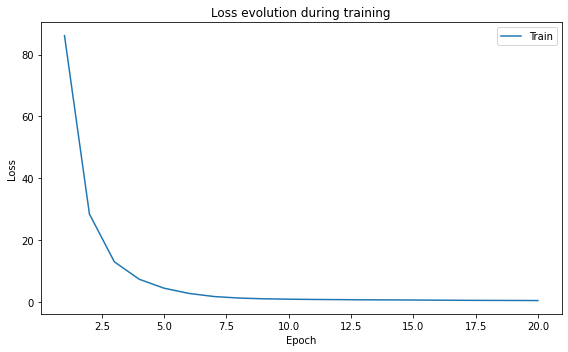

In [11]:
plot_curves(curves)

## Predicciones

In [12]:
class CustomDataset(Dataset):
    def __init__(self, root_dir,data,query,transform=None):
        self.root_dir = root_dir
        self.query= query
        self.transform = transform
        self.data =data
        
        self.file_list = data['qimlist'] if query else data['imlist']
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f'{self.file_list[idx]}.jpg')
        image = Image.open(img_name)
        
        if self.query:
            crop_limits = self.data["gnd"][idx]["bbx"]
            image = image.crop(crop_limits)

        if self.transform != None:
            image = self.transform(image)

        return image

In [13]:
def feature_extractor(dataset_name, model, preprocess, device):
    
    root_dir = f"revisitop/data/datasets/{dataset_name}/jpg"
    file = f"revisitop/data/datasets/{dataset_name}/gnd_{dataset_name}.pkl"
    with open(file, "rb") as f:
        data = pickle.load(f)

    db_dataset = CustomDataset(root_dir=root_dir, data=data,query=False, transform=preprocess)
    query_dataset = CustomDataset(root_dir=root_dir, data=data,query=True, transform=preprocess)
        
    db_features = []
    for imagen in tqdm(db_dataset, desc="Extrayendo Caracteristicas"):
        with torch.no_grad():
            features = model(imagen.unsqueeze(0).to(device))
            db_features.append(features.squeeze(0).cpu().numpy())

    querys_features = []
    for imagen in tqdm(query_dataset, desc="Extrayendo Caracteristicas"):
        with torch.no_grad():
            features = model(imagen.unsqueeze(0).to(device))
            querys_features.append(features.squeeze(0).cpu().numpy())
            
    db_features = np.vstack(db_features)
    querys_features = np.vstack(querys_features)  
    
    return db_features, querys_features

In [14]:
model_gem.eval()

GeM_ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [15]:
db_features_oxford, querys_features_oxford = feature_extractor("roxford5k",model_gem,preprocess,device=device)

Extrayendo Caracteristicas: 100%|██████████| 70/70 [00:01<00:00, 53.57it/s]


## Evaluacion

In [16]:
def evaluate(db,querys, data):
    
    cosine_sim = cosine_similarity(db, querys)
    ranks = np.argsort(cosine_sim, axis=0)[::-1]
    
    gnd = data['gnd']

    # evaluate ranks
    ks = [1,2,100]

    # search for easy
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['easy']])
        g['junk'] = np.concatenate([gnd[i]['junk'], gnd[i]['hard']])
        gnd_t.append(g)
    mapE, apsE, mprE, prsE = compute_map(ranks, gnd_t, ks)

    # search for easy & hard
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['easy'], gnd[i]['hard']])
        g['junk'] = np.concatenate([gnd[i]['junk']])
        gnd_t.append(g)
    mapM, apsM, mprM, prsM = compute_map(ranks, gnd_t, ks)

    # search for hard
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['hard']])
        g['junk'] = np.concatenate([gnd[i]['junk'], gnd[i]['easy']])
        gnd_t.append(g)
    mapH, apsH, mprH, prsH = compute_map(ranks, gnd_t, ks)

    print('>> {}: mAP E: {}, M: {}, H: {}'.format("roxford5k", np.around(mapE*100, decimals=2), np.around(mapM*100, decimals=2), np.around(mapH*100, decimals=2)))

In [17]:
evaluate(db_features_oxford,querys_features_oxford, data_roxford5k)

>> roxford5k: mAP E: 21.7, M: 16.16, H: 4.27


In [17]:
evaluate(db_features_oxford,querys_features_oxford, data_roxford5k)

>> roxford5k: mAP E: 9.23, M: 11.45, H: 5.47


## UMAP

In [109]:
labels_bool = np.full(len(db_features_oxford), True, dtype=bool)
labels_int = np.zeros(len(db_features_oxford))

totalxd= []
for i in tqdm(range(len(data_roxford5k['gnd'])), "Procesando"):
    easy_pos = data_roxford5k['gnd'][i]["easy"]
    hard_pos = data_roxford5k['gnd'][i]["hard"] 
    junk_pos = data_roxford5k['gnd'][i]["junk"]
    
    true_pos = easy_pos+hard_pos
    if len(set(totalxd).intersection(true_pos)) > 0:
        print("Hay elementos repetidos entre las dos listas.")
        print(i)
        break
    else:
        print("No hay elementos repetidos entre las dos listas.")
        
    totalxd+=true_pos
    



    all_pos = list(range(len(db_features_oxford)))
    
    mascara = list(map(lambda x: x in set(true_pos), all_pos))
    #mascara_all = list(map(lambda x: x in set(junk_pos), all_pos))
    
    labels_bool*=~np.array(mascara) 
    labels_int[mascara] = i

Procesando:   1%|▏         | 1/70 [00:00<00:01, 68.06it/s]

No hay elementos repetidos entre las dos listas.
Hay elementos repetidos entre las dos listas.
1


In [110]:
easy_pos = data_roxford5k['gnd'][0]["easy"]
hard_pos = data_roxford5k['gnd'][0]["hard"] 

true_pos = easy_pos+hard_pos

In [124]:
easy_pos = data_roxford5k['gnd'][1]["easy"]
easy_pos

[30,
 69,
 296,
 324,
 581,
 623,
 685,
 691,
 736,
 801,
 953,
 1125,
 1232,
 1318,
 1392,
 1520,
 1581,
 1619,
 1643,
 1688,
 1707,
 1754,
 2017,
 2194,
 2204,
 2221,
 2279,
 2293,
 2423,
 2588,
 2916,
 2918,
 2939,
 2956,
 3041,
 3268,
 3303,
 3313,
 3317,
 3349,
 3458,
 3534,
 3599,
 3620,
 3784,
 3797,
 3907,
 3985,
 4028,
 4035,
 4083,
 4093,
 4118,
 4157,
 4236,
 4255,
 4260,
 4290,
 4486,
 4644,
 4682,
 4900,
 4960,
 4969,
 4984]

In [113]:
easy_pos2 = data_roxford5k['gnd'][1]["easy"]
hard_pos2 = data_roxford5k['gnd'][1]["hard"] 

true_pos2 = easy_pos2+hard_pos2

In [116]:
len(easy_pos2)

65

In [118]:
len(lista_elementos_repetidos)

65

In [114]:
from collections import Counter



contador_lista1 = Counter(easy_pos)
contador_lista2 = Counter(easy_pos2)

elementos_repetidos = (contador_lista1 & contador_lista2).elements()

lista_elementos_repetidos = list(elementos_repetidos)

if lista_elementos_repetidos:
    print("Elementos repetidos entre las dos listas:", lista_elementos_repetidos)
else:
    print("No hay elementos repetidos entre las dos listas.")


Elementos repetidos entre las dos listas: [30, 69, 296, 324, 581, 623, 685, 691, 736, 801, 953, 1125, 1232, 1318, 1392, 1520, 1581, 1619, 1643, 1688, 1707, 1754, 2017, 2194, 2204, 2221, 2279, 2293, 2423, 2588, 2916, 2918, 2939, 2956, 3041, 3268, 3303, 3313, 3317, 3349, 3458, 3534, 3599, 3620, 3784, 3797, 3907, 3985, 4028, 4035, 4083, 4093, 4118, 4157, 4236, 4255, 4260, 4290, 4486, 4644, 4682, 4900, 4960, 4969, 4984]


In [107]:
if len(totalxd) != len(set(totalxd)):
    print("La lista tiene elementos repetidos.")
else:
    print("La lista no tiene elementos repetidos.")

La lista tiene elementos repetidos.


In [ ]:
totalxd

In [85]:
labels_bool.sum()

4205

In [88]:
labels_bool

array([ True,  True, False, ...,  True, False, False])

In [89]:
labels_int[labels_bool]

array([0., 0., 0., ..., 0., 0., 0.])

In [90]:
(labels_int[labels_bool]==0).sum()

4205

In [23]:
easy_pos = data_roxford5k['gnd'][0]["easy"]
hard_pos = data_roxford5k['gnd'][0]["hard"] 

true_pos = easy_pos+hard_pos

In [34]:
labels = np.zeros(len(data_roxford5k['imlist']))
labels

array([0., 0., 0., ..., 0., 0., 0.])

In [27]:
all_pos = list(range(len(db_features_oxford)))
all_pos[-1]

4992

In [32]:
mascara = list(map(lambda x: x in set(true_pos), all_pos))
np.array(mascara).sum()

103

In [24]:
len(true_pos)

103

In [48]:
labels

array([False, False,  True, ..., False,  True,  True])

In [51]:
(labels_int==0).sum()

4205

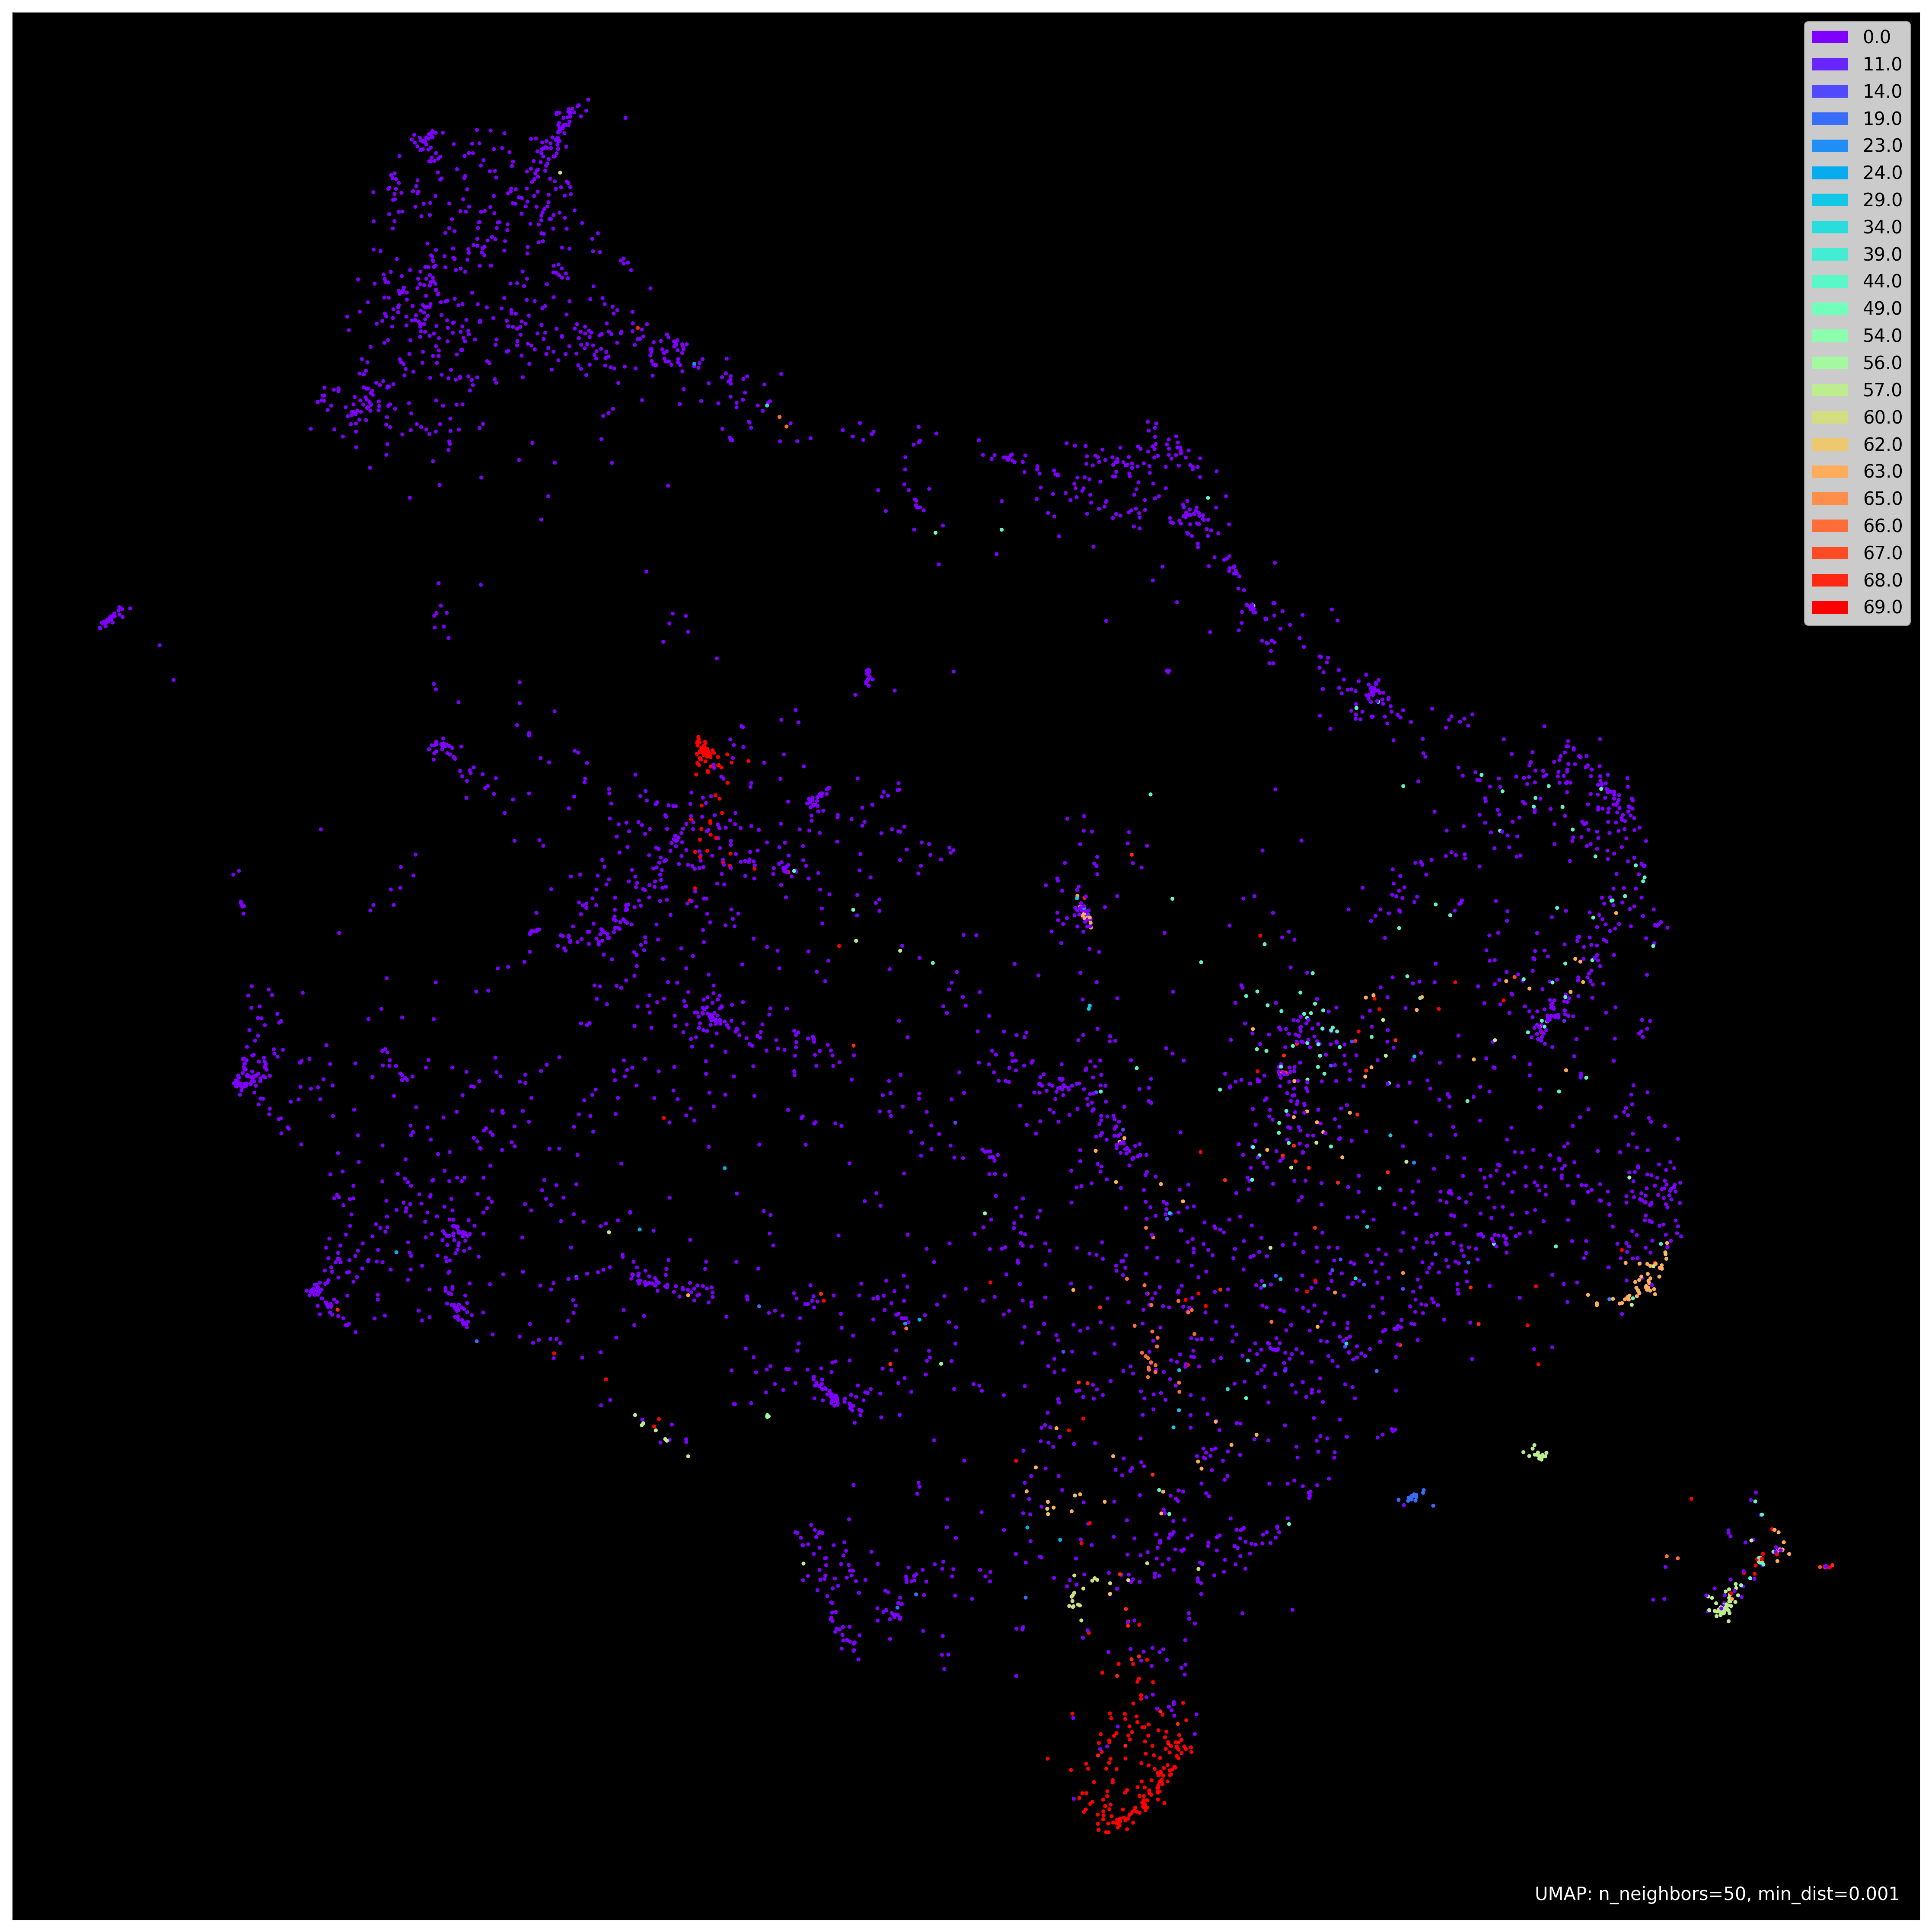

In [46]:
mapper = umap.UMAP(n_neighbors=50, min_dist=0.001, random_state=48, n_jobs=1).fit(db_features_oxford)

fig, ax = plt.subplots(figsize=(15, 15), dpi=300)
umap.plot.points(mapper, labels=labels, theme='fire',ax=ax)
plt.tight_layout()
plt.show()

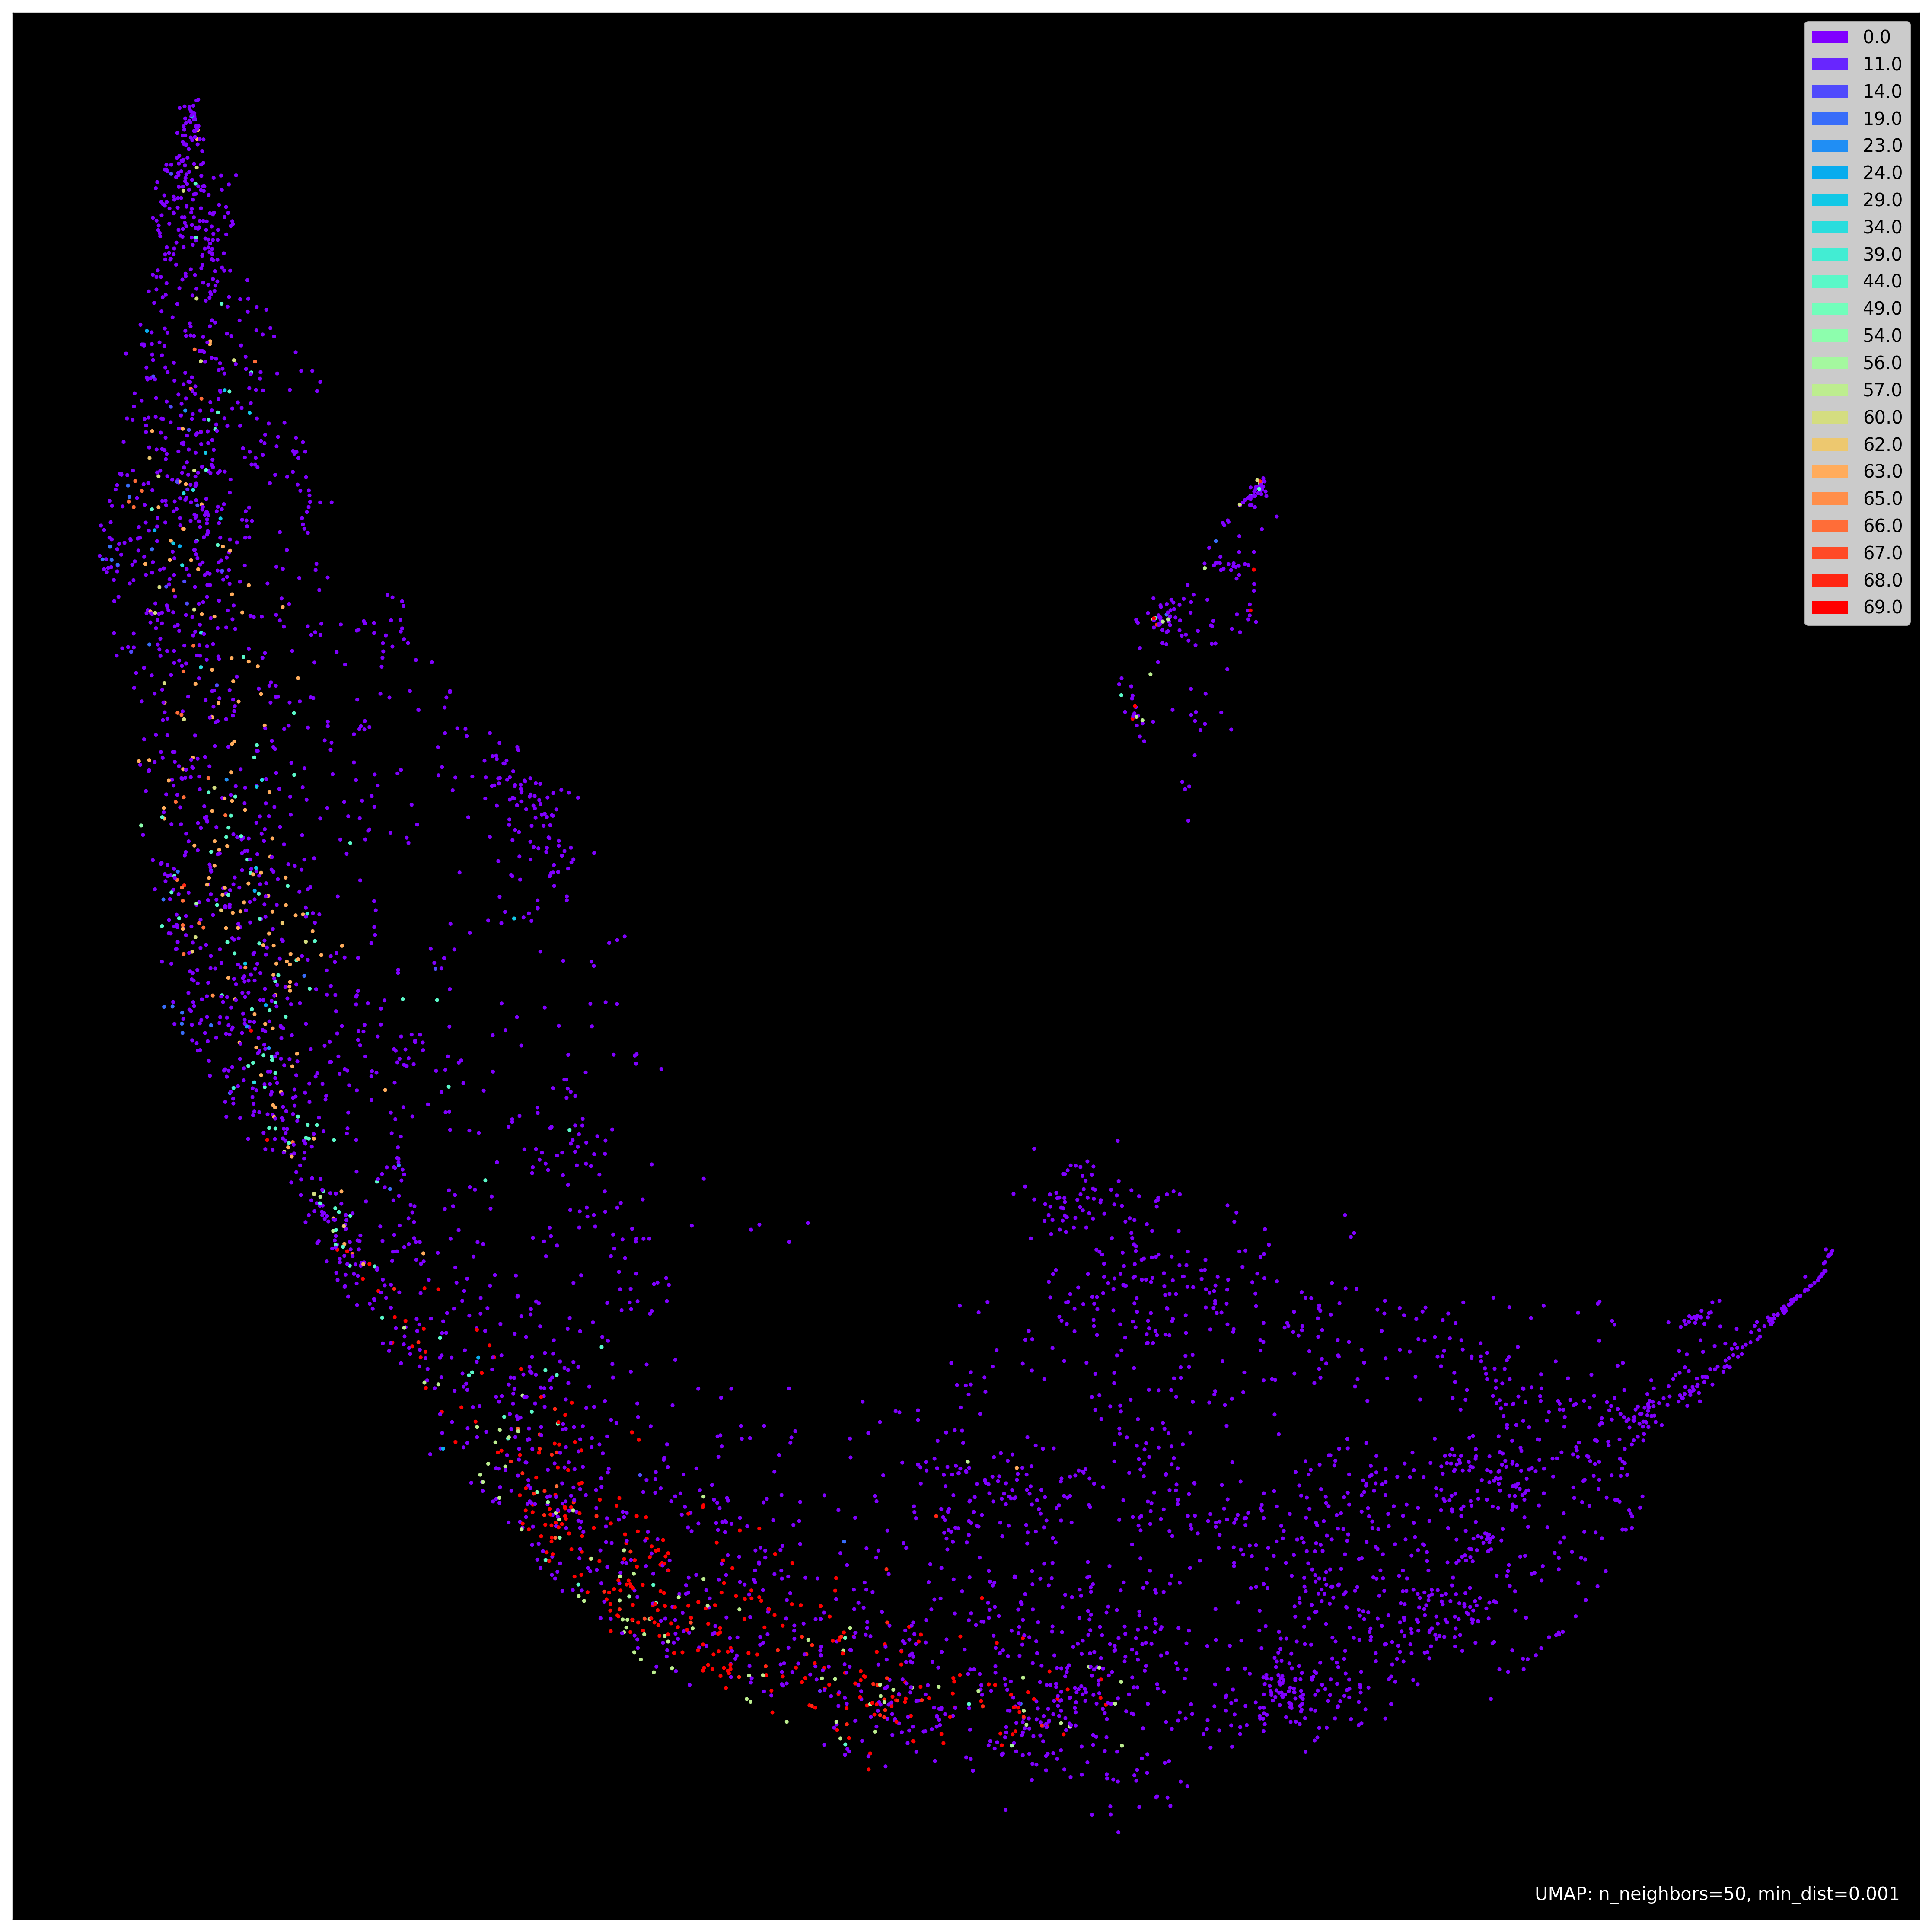

In [19]:
mapper = umap.UMAP(n_neighbors=50, min_dist=0.001, random_state=48, n_jobs=1).fit(db_features_oxford)

fig, ax = plt.subplots(figsize=(15, 15), dpi=300)
umap.plot.points(mapper, labels=labels, theme='fire',ax=ax)
plt.tight_layout()
plt.show()